In [1]:
import numpy as np
import matplotlib.pyplot as plt
import copy
# From https://github.com/mrphysics-bonn/skipped-caipi:
from skippedcaipi.skippedcaipi import elementary_sampling, get_trajectory_indices, plot_parabola_connection, get_zblips, get_zblipcycle

# Skipped-CAIPI<sup>1</sup> sampling class

This will provide basic functionality to generate CAIPIRINHA sampling mask and a skipped-CAIPI view ordering list from the specified phase encoding matrix size and CAIPI parameters. This can be used for blipped-CAIPI<sup>2</sup>, shot-selective CAIPI<sup>3,4</sup> (without z-blips) or any other skipped-CAIPI<sup>1</sup> sampling.

Note: skipped-CAIPI was developed for 3D-EPI, but in principle it should be applicable to SMS-EP as well<sup>5</sup>. The blips should remain the same, only the initial phase encoders must be realized differently in SMS-EPI (via RF phase?).

1. Stirnberg, R., & Stöcker, T. (2021). Segmented K‐space blipped‐controlled aliasing in parallel imaging for high spatiotemporal resolution EPI. Magnetic Resonance in Medicine, 85(3), 1540–1551. https://doi.org/10.1002/mrm.28486
1. Setsompop, K., Gagoski, B. A., Polimeni, J. R., Witzel, T., Wedeen, V. J., & Wald, L. L. (2012). Blipped-controlled aliasing in parallel imaging for simultaneous multislice echo planar imaging with reduced g-factor penalty. Magnetic Resonance in Medicine, 67(5), 1210–1224. https://doi.org/10.1002/mrm.23097
1. Poser, B. A., Ivanov, D., Kannengiesser, S. A., Uludağ, K., & Barth, M. (2014). Accelerated 3D EPI using 2D blipped-CAIPI for high temporal and/or spatial resolution. Proceedings of the International Society of Magnetic Resonance in Medicine, 22, 1506.
1. Hendriks, A. D., D’Agata, F., Raimondo, L., Schakel, T., Geerts, L., Luijten, P. R., Klomp, D. W. J., & Petridou, N. (2020). Pushing functional MRI spatial and temporal resolution further: High-density receive arrays combined with shot-selective 2D CAIPIRINHA for 3D echo-planar imaging at 7 T. NMR in Biomedicine, 33(5), 1–13. https://doi.org/10.1002/nbm.4281
1. Zahneisen, B., Poser, B. A., Ernst, T., & Stenger, V. A. (2014). Three-dimensional Fourier encoding of simultaneously excited slices: Generalized acquisition and reconstruction framework. Magnetic Resonance in Medicine, 71(6), 2071–2081. https://doi.org/10.1002/mrm.24875

In [2]:
class skippedcaipi_sampling:
    def __init__(self, matrix_size_y, matrix_size_z, Ry, Rz, CaipiShiftZ, SegmentationFactor=1):
        self.matrix_size = [matrix_size_y, matrix_size_z]
        self.R = [Ry,Rz]
        self.D = CaipiShiftZ
        self.S = SegmentationFactor
        
        self.mask = self.samplingmask()
        self.samples = np.sum(self.mask)
        
        # update actual matrix size
        self.matrix_size = self.mask.shape
        
        self.sampling_repeats_z = self.matrix_size[1]//self.R[1]
        self.shots_to_measure = self.sampling_repeats_z * self.S
        
        self.indices = self.viewordering()
        
        self.zblips = get_zblips(self.R[0], self.R[1], self.D, self.S)
        self.zblip_cycle = get_zblipcycle(self.R[1],np.min(self.zblips))
        

    def has_zblips(self):
        return (self.zblip_cycle!=1)
    
    def epi_factor(self, shot=None):
        if shot < 0 or shot >= self.shots_to_measure:
            return -1 # in valid
        else:
            return self.indices[shot].shape[0]
        
    def samplingmask(self):
        Rtot = np.prod(self.R)
        sampling_cell_repeats_y = int(np.ceil(self.matrix_size[0]*1.0/Rtot))
        sampling_cell_repeats_z = int(np.ceil(self.matrix_size[1]*1.0/Rtot)) 

        # Along y, it is not necessary that the matrix size is divisable by Rtot.
        mask = elementary_sampling(self.R[0], self.R[1], self.D, sampling_cell_repeats_y-1).T
        mask = mask[:self.matrix_size[0],:]
        
        # Along z, it can make sense that the matrix size (number of "slices") are divisable by Rz.
        mask = np.tile(mask, (1,sampling_cell_repeats_z))
        mask = mask[:,:int(np.ceil(self.matrix_size[1]*1.0/Rz)*Rz)]
    
        return mask
    
    def viewordering(self):
        # First S shots ...
        sampling_template = [get_trajectory_indices(self.mask.T, segmentation=self.S, shot=s) for s in range(self.S)]
        sampling_indices = []
        # ... that are repeated for subsequent k-space partitions
        for instance in range(self.sampling_repeats_z):
            sampling_indices += copy.deepcopy(sampling_template)
            partition_offset = self.R[1] * instance
            for s in range(self.S):
                # Add partition offset
                sampling_indices[-self.S+s][:,0] += partition_offset
                
        return sampling_indices
    
    def plot(self, axes=None, shots=None):
        if not axes:
            axes = plt.gca()
            
        if shots==None:
            shots = range(self.shots_to_measure)

        axes.imshow(self.mask.T, cmap='gray')

        # color of trajectories encodes time:
        colors = plt.cm.hot(np.linspace(0,1,self.samples-1))
        sample = 0
        
        for s in shots:
            if s>=0 and s < self.shots_to_measure:
                actual_epi_factor = self.indices[s].shape[0]
                for echo in range(actual_epi_factor-1):
                    if not self.has_zblips():
                        plt.plot(self.indices[s][echo:echo+2,1], self.indices[s][echo:echo+2,0], color=colors[sample])
                    else:
                        #A little more realistic phase encode trajectory between echoes is plotted:
                        plot_parabola_connection(self.indices[s][echo,::-1], self.indices[s][echo+1,::-1], axis=axes, num=11, color=colors[sample], bRotate=False)
                    sample += 1

        axes.set_ylabel('Parts')
        axes.set_xlabel('Lines')

# Use the sampling class

## 1. Define basic sampling parameters

In [3]:
Ry=1 # Undersampling factor along y (primary phase encode direction, w.l.o.g.)
Rz=6 # Undersampling factor along z (slice direction, w.l.o.g.)
Dz=2 # CAIPI shift along z
S=2  # Segmentation factor (typically 1, for fMRI)

matrix_size_y = 64
matrix_size_z = 30

## 2. Generate and plot different EPI CAIPI sampling schemes

### A) Blipped-CAIPI
(typical for fMRI)

This is a skipped-CAIPI sampling without segmentation (SegmentationFactor=1).

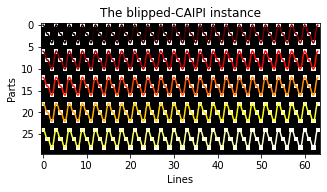

In [4]:
# Create the blipped-CAIPI instance linked to the CAIPI pattern (Segmentation Factor = 1)
blippedcaipi = skippedcaipi_sampling(matrix_size_y, matrix_size_z, Ry, Rz, Dz, SegmentationFactor=1)

plt.figure(figsize=(5,10))
blippedcaipi.plot()
plt.title('The blipped-CAIPI instance')
plt.show()

### B) Shot-selective CAIPI

(often expressed by alternate CAIPI notation of the identical pattern using a y-CAIPI shift)

This is a skipped-CAIPI sampling with the smallest segmentation factor that results in no z-blips, which is the z-blip cycle of the non-segmented blipped-CAIPI sampling.

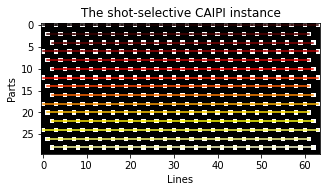

In [5]:
# Create the shot-selective instance linked to the CAIPI pattern (Segmentation Factor = z-blip cycle of the non-segmented blipped-CAIPI sampling)
shotselcaipi = skippedcaipi_sampling(matrix_size_y, matrix_size_z, Ry, Rz, Dz, SegmentationFactor=blippedcaipi.zblip_cycle)

plt.figure(figsize=(5,10))
shotselcaipi.plot()
plt.title('The shot-selective CAIPI instance')
plt.show()

### C) Skipped-CAIPI
(let's try two examples)

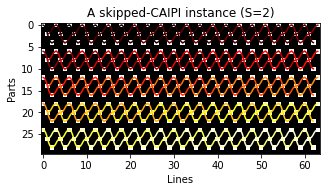

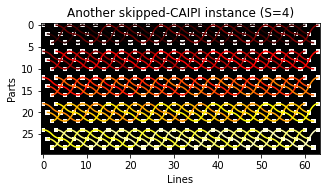

In [6]:
# Create a skipped-CAIPI instance linked to the CAIPI pattern (Segmentation Factor = any other value but 1 or the z-blip cycle of the non-segmented blipped-CAIPI sampling)

if blippedcaipi.zblip_cycle>2:
    S=2
else:
    S=blippedcaipi.zblip_cycle+1
    
skippedcaipi1 = skippedcaipi_sampling(matrix_size_y, matrix_size_z, Ry, Rz, Dz, SegmentationFactor=S)

plt.figure(figsize=(5,10))
skippedcaipi1.plot()
plt.title('A skipped-CAIPI instance (S=%d)'%(S))
plt.show()

if blippedcaipi.zblip_cycle>3:
    S=3
else:
    S=4

skippedcaipi2 = skippedcaipi_sampling(matrix_size_y, matrix_size_z, Ry, Rz, Dz, SegmentationFactor=S)

plt.figure(figsize=(5,10))
skippedcaipi2.plot()
plt.title('Another skipped-CAIPI instance (S=%d)'%(S))
plt.show()

# Understanding the sampling.indices list

This is what is going to be used in an actual sequence that loops over shots and applies the phase encoders accordingly.

More specifically: the initial phase encoders will use the indices of the first (part/line) pair per shot and the phase encode blips will use the difference of the next (part/line) pair to the current (part/line) pair.

Note: the k-space center index is not (yet) defined in the sampling class (it will always include the (part/line)=(0/0) pair). The user may want to off-set the phase encoding accordingly, or not.

In [7]:
print('The indices list has as many indices as shots to measure (per volume)')
print(shotselcaipi.shots_to_measure, len(shotselcaipi.indices))

print('The EPI factor corresponds to the number of (part/line) pairs bundled in an array per shot')
print(shotselcaipi.indices[0].shape)
print('Note: in segmented (S>1) sampling schemes, the EPI factor may vary from shot-to-shot. Get the actual EPI factor array size conveniently:')
print(shotselcaipi.epi_factor(shot=0))
print(shotselcaipi.epi_factor(shot=1))
print(shotselcaipi.epi_factor(shot=2))
print(shotselcaipi.epi_factor(shot=3))

print('The echo is adreessed via the first array dimension (size = EPI factor)')
print('The second array dimension (size = 2) returns the partition and the line index')
for echo in range(blippedcaipi.epi_factor(0)//2):
    print(echo, blippedcaipi.indices[0][echo,:])

The indices list has as many indices as shots to measure (per volume)
15 15
The EPI factor corresponds to the number of (part/line) pairs bundled in an array per shot
(22, 2)
Note: in segmented (S>1) sampling schemes, the EPI factor may vary from shot-to-shot. Get the actual EPI factor array size conveniently:
22
21
21
22
The echo is adreessed via the first array dimension (size = EPI factor)
The second array dimension (size = 2) returns the partition and the line index
0 [0 0]
1 [2 1]
2 [4 2]
3 [0 3]
4 [2 4]
5 [4 5]
6 [0 6]
7 [2 7]
8 [4 8]
9 [0 9]
10 [ 2 10]
11 [ 4 11]
12 [ 0 12]
13 [ 2 13]
14 [ 4 14]
15 [ 0 15]
16 [ 2 16]
17 [ 4 17]
18 [ 0 18]
19 [ 2 19]
20 [ 4 20]
21 [ 0 21]
22 [ 2 22]
23 [ 4 23]
24 [ 0 24]
25 [ 2 25]
26 [ 4 26]
27 [ 0 27]
28 [ 2 28]
29 [ 4 29]
30 [ 0 30]
31 [ 2 31]
